# Machine Learning with PyTorch and Scikit-Learn  

## Ben Ganon - 318731007

## Omri Ben Hemo - 313255242

In [330]:
import sys
sys.path.insert(0, '..')

In [331]:
from sklearn.metrics import roc_auc_score
def macro_auc_score(y_true, probas, num_classes=10):
    return roc_auc_score(y_true, probas, average='macro', multi_class='ovr')

In [332]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [333]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

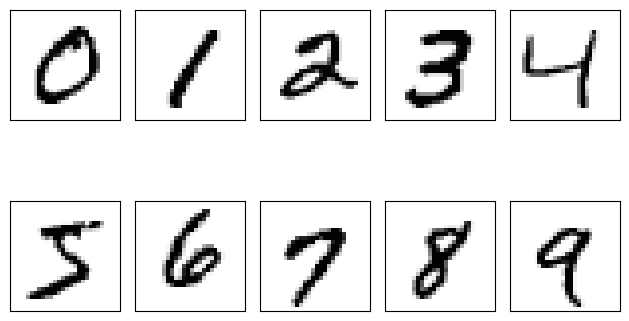

In [334]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

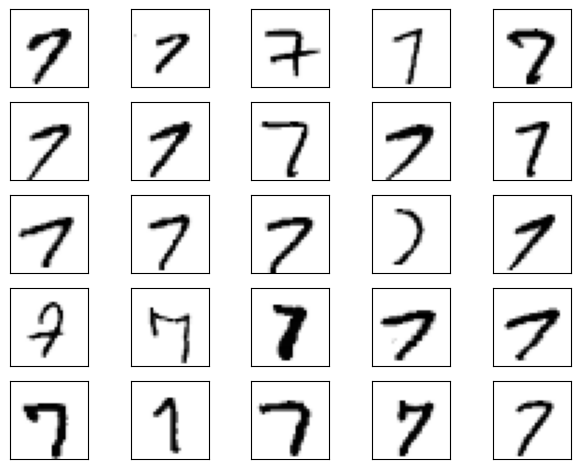

In [335]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [336]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=42, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp

<br>
<br>

#One-Layer Perceptron

In [337]:
import numpy as np

In [338]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [339]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [340]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [341]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [342]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [343]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


In [344]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [345]:
np.random.seed(42) # for the training set shuffling



epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=30, learning_rate=0.1)

Epoch: 001/030 | Train MSE: 0.05 | Train Acc: 76.91% | Valid Acc: 77.52%
Epoch: 002/030 | Train MSE: 0.03 | Train Acc: 85.79% | Valid Acc: 86.48%
Epoch: 003/030 | Train MSE: 0.02 | Train Acc: 88.02% | Valid Acc: 88.90%
Epoch: 004/030 | Train MSE: 0.02 | Train Acc: 89.35% | Valid Acc: 90.22%
Epoch: 005/030 | Train MSE: 0.02 | Train Acc: 90.03% | Valid Acc: 90.72%
Epoch: 006/030 | Train MSE: 0.02 | Train Acc: 90.58% | Valid Acc: 91.20%
Epoch: 007/030 | Train MSE: 0.02 | Train Acc: 91.07% | Valid Acc: 91.54%
Epoch: 008/030 | Train MSE: 0.02 | Train Acc: 91.51% | Valid Acc: 91.96%
Epoch: 009/030 | Train MSE: 0.01 | Train Acc: 91.68% | Valid Acc: 92.18%
Epoch: 010/030 | Train MSE: 0.01 | Train Acc: 92.01% | Valid Acc: 92.54%
Epoch: 011/030 | Train MSE: 0.01 | Train Acc: 92.20% | Valid Acc: 92.76%
Epoch: 012/030 | Train MSE: 0.01 | Train Acc: 92.41% | Valid Acc: 92.92%
Epoch: 013/030 | Train MSE: 0.01 | Train Acc: 92.59% | Valid Acc: 93.12%
Epoch: 014/030 | Train MSE: 0.01 | Train Acc: 92.84

## Evaluating the neural network performance

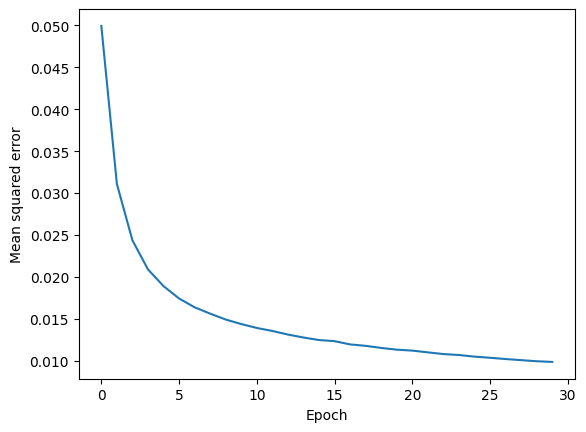

In [346]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

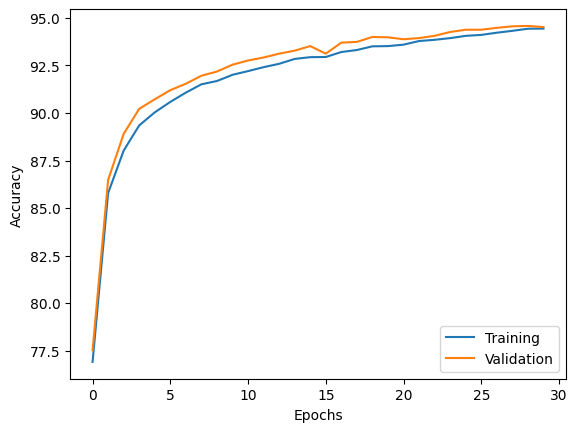

In [347]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [348]:
one_layer_mse, one_layer_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {one_layer_acc*100:.2f}%')

_, test_probas = model.forward(X_test)
test_probas = torch.softmax(torch.tensor(test_probas), dim=-1)
one_layer_auc = macro_auc_score(y_test, test_probas)

Test accuracy: 93.70%


Plot failure cases:

In [349]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

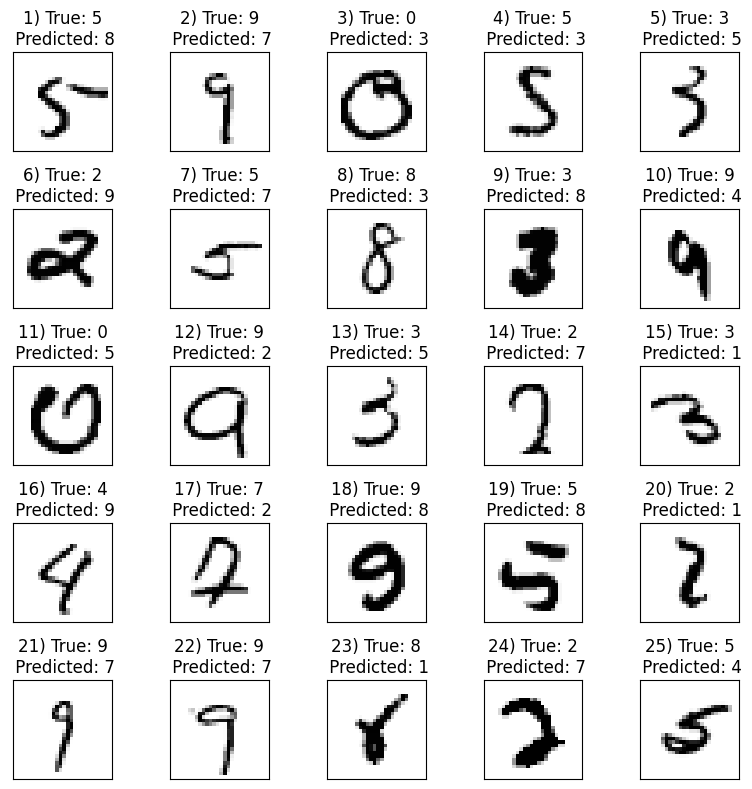

In [350]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

#Task 3: Two-Layer Perceptron

##Load train val split

In [351]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=42, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp

## Implementing a 2-layer perceptron

In [363]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.datasets import mnist
import math
import torch

# Load original MNIST from Keras
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

# Combine everything into a single dataset of size 70k
X_all = np.concatenate([X_train_full, X_test_full], axis=0)
y_all = np.concatenate([y_train_full, y_test_full], axis=0)

# Flatten each 28x28 image into a 1D vector of length 784
X_all = X_all.reshape(X_all.shape[0], 28*28).astype(np.float32)

# Normalize inputs to [0, 1]
X_all /= 255.0

# 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.30, random_state=123, shuffle=True)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set:  {X_test.shape}, {y_test.shape}")

Train set: (49000, 784), (49000,)
Test set:  (21000, 784), (21000,)


In [353]:
import numpy as np

In [354]:

class TwoLayerNN:
    def __init__(self, input_layer_size, hidden_layer1_size, hidden_layer2_size, output_layer_size, learning_rate=0.01):
        # Initialize weights and biases
        self.weights_input_to_hidden1 = np.random.randn(input_layer_size, hidden_layer1_size) * 0.01
        self.bias_hidden_layer1 = np.zeros((1, hidden_layer1_size))

        self.weights_hidden1_to_hidden2 = np.random.randn(hidden_layer1_size, hidden_layer2_size) * 0.01
        self.bias_hidden_layer2 = np.zeros((1, hidden_layer2_size))

        self.weights_hidden2_to_output = np.random.randn(hidden_layer2_size, output_layer_size) * 0.01
        self.bias_output_layer = np.zeros((1, output_layer_size))

        self.learning_rate = learning_rate

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def one_hot_encode(self, labels, num_classes=10):
        return np.eye(num_classes)[labels]

    def forward(self, input_data):
        hidden_layer1_input = np.dot(input_data, self.weights_input_to_hidden1) + self.bias_hidden_layer1
        hidden_layer1_activation = self.sigmoid(hidden_layer1_input)

        hidden_layer2_input = np.dot(hidden_layer1_activation, self.weights_hidden1_to_hidden2) + self.bias_hidden_layer2
        hidden_layer2_activation = self.sigmoid(hidden_layer2_input)

        output_layer_input = np.dot(hidden_layer2_activation, self.weights_hidden2_to_output) + self.bias_output_layer
        output_layer_activation = self.sigmoid(output_layer_input)

        self.hidden_layer1_activation = hidden_layer1_activation
        self.hidden_layer2_activation = hidden_layer2_activation

        return output_layer_activation

    def backward(self, input_data, target_output, output_layer_activation):
        # Compute error
        output_error = output_layer_activation - target_output
        hidden_layer1_activation = self.hidden_layer1_activation
        hidden_layer2_activation = self.hidden_layer2_activation
        # Backpropagation
        output_layer_gradient = output_error * self.sigmoid_derivative(output_layer_activation)
        gradient_weights_hidden2_to_output = np.dot(hidden_layer2_activation.T, output_layer_gradient)
        gradient_bias_output_layer = np.sum(output_layer_gradient, axis=0, keepdims=True)

        hidden_layer2_gradient = np.dot(output_layer_gradient, self.weights_hidden2_to_output.T) * self.sigmoid_derivative(hidden_layer2_activation)
        gradient_weights_hidden1_to_hidden2 = np.dot(hidden_layer1_activation.T, hidden_layer2_gradient)
        gradient_bias_hidden_layer2 = np.sum(hidden_layer2_gradient, axis=0, keepdims=True)

        hidden_layer1_gradient = np.dot(hidden_layer2_gradient, self.weights_hidden1_to_hidden2.T) * self.sigmoid_derivative(hidden_layer1_activation)
        gradient_weights_input_to_hidden1 = np.dot(input_data.T, hidden_layer1_gradient)
        gradient_bias_hidden_layer1 = np.sum(hidden_layer1_gradient, axis=0, keepdims=True)

        self.weights_hidden2_to_output -= self.learning_rate * gradient_weights_hidden2_to_output
        self.bias_output_layer -= self.learning_rate * gradient_bias_output_layer

        self.weights_hidden1_to_hidden2 -= self.learning_rate * gradient_weights_hidden1_to_hidden2
        self.bias_hidden_layer2 -= self.learning_rate * gradient_bias_hidden_layer2

        self.weights_input_to_hidden1 -= self.learning_rate * gradient_weights_input_to_hidden1
        self.bias_hidden_layer1 -= self.learning_rate * gradient_bias_hidden_layer1

        return gradient_weights_hidden2_to_output, gradient_bias_output_layer, gradient_weights_hidden1_to_hidden2, gradient_bias_hidden_layer2, gradient_weights_input_to_hidden1, gradient_bias_hidden_layer1


## Coding the neural network training loop

Defining a function to compute the loss and accuracy

In [355]:
def compute_mse_and_acc(model, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        if not isinstance(features, torch.Tensor):
            features = torch.tensor(features, dtype=torch.float32)

        probas = model.forward(features)

        # Convert probas and targets to NumPy arrays before calculating MSE
        probas = probas.detach().detach().numpy() if isinstance(probas, torch.Tensor) else probas
        targets = targets.detach().detach().numpy() if isinstance(targets, torch.Tensor) else targets

        loss = np.mean((targets - probas)**2)
        predicted_labels = np.argmax(probas, axis=1)
        targets_class = np.argmax(targets, axis=1)
        correct_pred += (predicted_labels == targets_class).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [356]:
model_two_layers = TwoLayerNN(
    input_layer_size=28*28,
    hidden_layer1_size=100,
    hidden_layer2_size=100,
    output_layer_size=10,
)

In [357]:

import numpy as np

num_epochs = 30
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]

def check_minibatch_generator(model, X, y, minibatch_size = 50):
    y = model.one_hot_encode(y)
    for i in range(num_epochs):
        minibatch_gen = minibatch_generator(
            X, y, minibatch_size)

        for X_mini, y_mini in minibatch_gen:

            break

        break

    print(X_mini.shape)
    print(y_mini.shape)


def train_two_layer_nn(model, X_train, y_train, X_test, y_test,
                  num_epochs=num_epochs, learning_rate=0.1, minibatch_size=100):
    # One-hot encode the labels
    y_train = model.one_hot_encode(y_train)
    y_test = model.one_hot_encode(y_test)
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_mini, y_mini in minibatch_gen:
            # Forward pass
            a_out = model.forward(X_mini)

            # Backward pass
            dW_out, dB_out, dW_h2, dB_h2, dW_h1, dB_h1 = \
                model.backward(X_mini, y_mini, a_out)


        # Logging macro AUC (assuming macro_auc_score function exists)
        test_probas = model.forward(X_test)
        # test_probas = np.argmax(test_probas, axis=1)
        # y_test = np.argmax(y_test, axis=1)
        test_auc = macro_auc_score(y_test, test_probas, num_classes=10)
        print(f"[Epoch {e+1:02d}] Test Macro AUC: {test_auc:.3f}")

        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_test, y_test)

        epoch_loss.append(train_mse)
        epoch_train_acc.append(train_acc * 100)
        epoch_valid_acc.append(valid_acc * 100)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc*100:.2f}% '
              f'| Valid Acc: {valid_acc*100:.2f}%')


    return epoch_loss, epoch_train_acc, epoch_valid_acc


# check_minibatch_generator(model_two_layers, X_train, y_train)
# train_two_layer_nn(model_two_layers, X_train, y_train, X_test, y_test,
#                   num_epochs=50, learning_rate=0.1, minibatch_size=100)

In [358]:
np.random.seed(42) # for the training set shuffling
epoch_loss_2hidden, epoch_train_acc_2hidden, epoch_valid_acc_2hidden = train_two_layer_nn(
    model=model_two_layers,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    num_epochs=num_epochs,
    learning_rate=0.1,
    minibatch_size=minibatch_size
)

[Epoch 01] Test Macro AUC: 0.573
Epoch: 001/030 | Train MSE: 0.09 | Train Acc: 9.97% | Valid Acc: 9.48%
[Epoch 02] Test Macro AUC: 0.604
Epoch: 002/030 | Train MSE: 0.09 | Train Acc: 10.51% | Valid Acc: 10.20%
[Epoch 03] Test Macro AUC: 0.629
Epoch: 003/030 | Train MSE: 0.09 | Train Acc: 11.16% | Valid Acc: 11.47%
[Epoch 04] Test Macro AUC: 0.658
Epoch: 004/030 | Train MSE: 0.09 | Train Acc: 10.04% | Valid Acc: 9.86%
[Epoch 05] Test Macro AUC: 0.698
Epoch: 005/030 | Train MSE: 0.09 | Train Acc: 9.97% | Valid Acc: 9.48%
[Epoch 06] Test Macro AUC: 0.711
Epoch: 006/030 | Train MSE: 0.09 | Train Acc: 19.11% | Valid Acc: 19.11%
[Epoch 07] Test Macro AUC: 0.729
Epoch: 007/030 | Train MSE: 0.08 | Train Acc: 29.71% | Valid Acc: 29.57%
[Epoch 08] Test Macro AUC: 0.817
Epoch: 008/030 | Train MSE: 0.07 | Train Acc: 39.52% | Valid Acc: 39.05%
[Epoch 09] Test Macro AUC: 0.888
Epoch: 009/030 | Train MSE: 0.06 | Train Acc: 56.51% | Valid Acc: 56.62%
[Epoch 10] Test Macro AUC: 0.936
Epoch: 010/030 | T

## Evaluating the Two Layer Neural Network performance

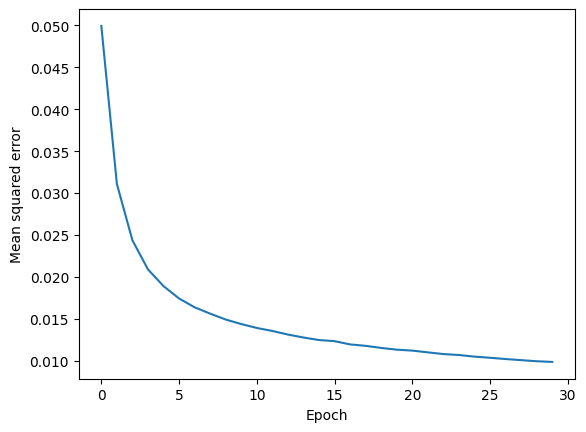

In [359]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

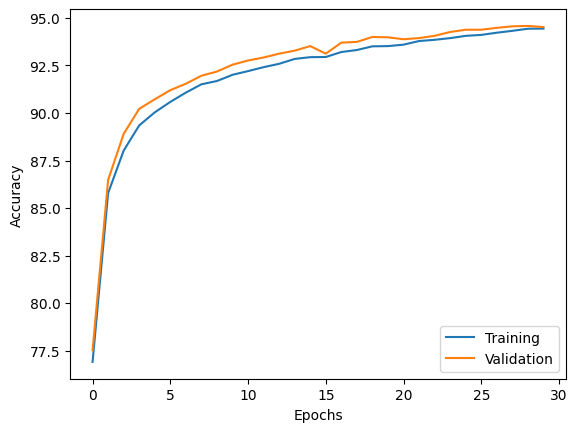

In [360]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [365]:
y_test_encoded = model_two_layers.one_hot_encode(y_test)
test_mse, test_acc = compute_mse_and_acc(model_two_layers, X_test, y_test_encoded)
print(f'Test accuracy: {test_acc*100:.2f}%')
test_probas = model_two_layers.forward(X_test)
two_layer_auc = macro_auc_score(y_test_encoded, test_probas, num_classes=10)
print(two_layer_auc)

Test accuracy: 95.03%
0.9943511471270161


# Task 4:  ANN architecture (with torch)

In [369]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.datasets import mnist
import math
import torch

In [370]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.datasets import mnist
import math
import torch

# Load original MNIST from Keras
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

# Combine everything into a single dataset of size 70k
X_all = np.concatenate([X_train_full, X_test_full], axis=0)
y_all = np.concatenate([y_train_full, y_test_full], axis=0)

# Flatten each 28x28 image into a 1D vector of length 784
X_all = X_all.reshape(X_all.shape[0], 28*28).astype(np.float32)

# Normalize inputs to [0, 1]
X_all /= 255.0

# 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.30, random_state=123, shuffle=True)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set:  {X_test.shape}, {y_test.shape}")

Train set: (49000, 784), (49000,)
Test set:  (21000, 784), (21000,)


In [371]:
class TwoLayerNNTorch(torch.nn.Module):
    def __init__(self, input_size, layer_1_size, layer_2_size, output_size):
        super(TwoLayerNNTorch, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, layer_1_size)
        self.fc2 = torch.nn.Linear(layer_1_size, layer_2_size)
        self.fc3 = torch.nn.Linear(layer_2_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)
        x = torch.softmax(x, dim=-1)
        return x

    def one_hot_encode(self, labels, num_classes=10):
        return np.eye(num_classes)[labels]


In [372]:
def train_two_layer_nn_torch(model, X_train, y_train, X_test, y_test,
                  num_epochs=30, learning_rate=0.0001, minibatch_size=100):
    # One-hot encode the labels
    y_train = model.one_hot_encode(y_train)
    y_test = model.one_hot_encode(y_test)
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_mini, y_mini in minibatch_gen:
            # Convert NumPy arrays to PyTorch tensors
            X_mini.requires_grad_(True)
            y_mini.requires_grad_(True)
            # Forward pass
            a_out = model(X_mini)
            loss = criterion(a_out, y_mini)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        # Logging macro AUC (assuming macro_auc_score function exists)
        test_probas = model.forward(X_test).detach().numpy()
        # test_probas = np.argmax(test_probas, axis=1)
        # y_test = np.argmax(y_test, axis=1)
        test_auc = macro_auc_score(y_test, test_probas, num_classes=10)
        print(f"[Epoch {e+1:02d}] Test Macro AUC: {test_auc:.3f}")

        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_test, y_test)

        epoch_loss.append(train_mse)
        epoch_train_acc.append(train_acc * 100)
        epoch_valid_acc.append(valid_acc * 100)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc*100:.2f}% '
              f'| Valid Acc: {valid_acc*100:.2f}%')


    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [373]:
model_two_layer_torch = TwoLayerNNTorch(
    input_size=28*28,
    layer_1_size=100,
    layer_2_size = 100,
    output_size=10)

print("Training TwoLayerNNTorch:")
epoch_loss_torch, epoch_train_acc_torch, epoch_valid_acc_torch = \
train_two_layer_nn_torch(model_two_layer_torch, X_train, y_train, X_test, y_test, num_epochs=num_epochs)

Training TwoLayerNNTorch:
[Epoch 01] Test Macro AUC: 0.932
Epoch: 001/030 | Train MSE: 0.08 | Train Acc: 39.02% | Valid Acc: 38.38%
[Epoch 02] Test Macro AUC: 0.955
Epoch: 002/030 | Train MSE: 0.05 | Train Acc: 63.66% | Valid Acc: 62.64%
[Epoch 03] Test Macro AUC: 0.972
Epoch: 003/030 | Train MSE: 0.04 | Train Acc: 75.40% | Valid Acc: 74.34%
[Epoch 04] Test Macro AUC: 0.981
Epoch: 004/030 | Train MSE: 0.03 | Train Acc: 85.42% | Valid Acc: 85.02%
[Epoch 05] Test Macro AUC: 0.985
Epoch: 005/030 | Train MSE: 0.02 | Train Acc: 88.23% | Valid Acc: 87.66%
[Epoch 06] Test Macro AUC: 0.987
Epoch: 006/030 | Train MSE: 0.02 | Train Acc: 89.38% | Valid Acc: 88.86%
[Epoch 07] Test Macro AUC: 0.989
Epoch: 007/030 | Train MSE: 0.02 | Train Acc: 90.20% | Valid Acc: 89.68%
[Epoch 08] Test Macro AUC: 0.990
Epoch: 008/030 | Train MSE: 0.02 | Train Acc: 90.74% | Valid Acc: 90.17%
[Epoch 09] Test Macro AUC: 0.991
Epoch: 009/030 | Train MSE: 0.01 | Train Acc: 91.22% | Valid Acc: 90.73%
[Epoch 10] Test Macr

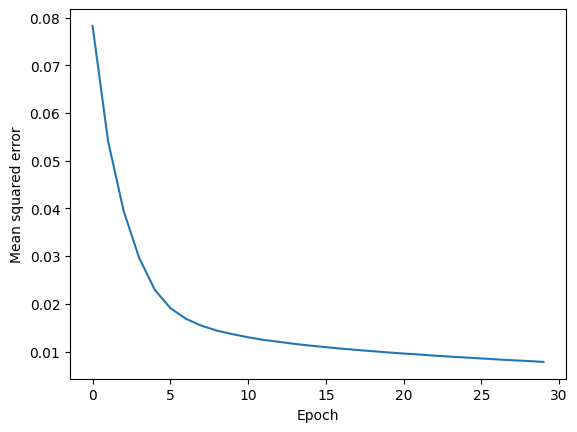

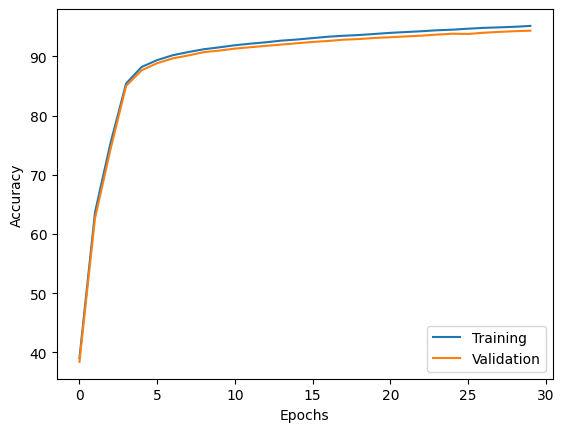

In [374]:
plt.plot(range(len(epoch_loss_torch)), epoch_loss_torch)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()
plt.plot(range(len(epoch_train_acc_torch)), epoch_train_acc_torch,
         label='Training')
plt.plot(range(len(epoch_valid_acc_torch)), epoch_valid_acc_torch,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [375]:
y_test = model_two_layer_torch.one_hot_encode(y_test)
test_mse, test_acc = compute_mse_and_acc(model_two_layer_torch, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
test_probas = model_two_layer_torch.forward(X_test).detach().numpy()
torch_two_layer_auc = macro_auc_score(y_test, test_probas, num_classes=10)
print(torch_two_layer_auc)

Test accuracy: 94.36%
0.9963968615762312


# Task 4: Compare the models

In [376]:
print(f"One Layer Perceptron Micro-AUC: {one_layer_auc:.3f}")
print(f"Two Layer Perceptron Micro-AUC: {two_layer_auc:.3f}")
print(f"Two Layer Perceptron PyTorch Micro-AUC: {torch_two_layer_auc:.3f}")

One Layer Perceptron Micro-AUC: 0.996
Two Layer Perceptron Micro-AUC: 0.994
Two Layer Perceptron PyTorch Micro-AUC: 0.996
